<a href="https://colab.research.google.com/github/TMhdSofyan/Convergence_Analysis/blob/main/Revised_Degree11_Tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/THESIS/Data/Experimental_Design2.csv')
df.tail()

,ID,Generator,Status,Result Status,Proxy Role,Keep SR3,Has SR3,Rating,CCPOR,KRG,...,PERMK_MULTI,POR_MULTI,SORW,Cum_Oil,Cum_Gas,Execution Node,Dataset Path,Optimal,MCMC Count,Comment
17072,17072,User,Complete,NormalTermination,Training,Auto,False,0,0.000005,0.531235,...,1.159760,0.997680,0.100961,1643914.0,317224130.0,77-1134-41,SA.cmsd\SA_17072.dat,False,0,NaN
17073,17073,User,Complete,NormalTermination,Training,Auto,False,0,0.000004,0.499895,...,0.870061,1.156218,0.108906,1661441.1,330066270.0,77-1134-41,SA.cmsd\SA_17073.dat,False,0,NaN
17074,17074,User,Complete,NormalTermination,Training,Auto,False,0,0.000004,0.509262,...,0.960209,0.982429,0.100172,1584137.9,315742180.0,77-1134-41,SA.cmsd\SA_17074.dat,False,0,NaN
17075,17075,User,Complete,NormalTermination,Training,Auto,False,0,0.000005,0.504134,...,1.041308,1.062378,0.090308,1632599.6,327702820.0,77-1134-41,SA.cmsd\SA_17075.dat,False,0,NaN
17076,17076,User,Complete,NormalTermination,Training,Auto,False,0,0.000005,0.431177,...,1.219194,1.158148,0.097388,1668201.6,328796160.0,77-1134-41,SA.cmsd\SA_17076.dat,False,0,NaN


In [ ]:
!pip3 install UQpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 kB 20.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=6de450e890f04abb7fe51ec9276fb971b176a1f7be0aada34823a8dd03bfd740
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
df2 = df.drop(columns = ['ID', 'Generator', 'Status', 'Result Status', 'Proxy Role', 'Keep SR3',
       'Has SR3', 'Rating','KRG', 'KRO', 'KRW', 'NG', 'NW','PERMK_MULTI', 'SORW', 'Cum_Gas',
       'Execution Node', 'Dataset Path', 'Optimal', 'MCMC Count', 'Comment'])
df2.tail()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil
17072,0.000005,1.002530,0.997680,1643914.0
17073,0.000004,1.020072,1.156218,1661441.1
17074,0.000004,0.787814,0.982429,1584137.9
17075,0.000005,0.881290,1.062378,1632599.6
17076,0.000005,1.074085,1.158148,1668201.6


In [ ]:
df2.shape

(17077, 4)

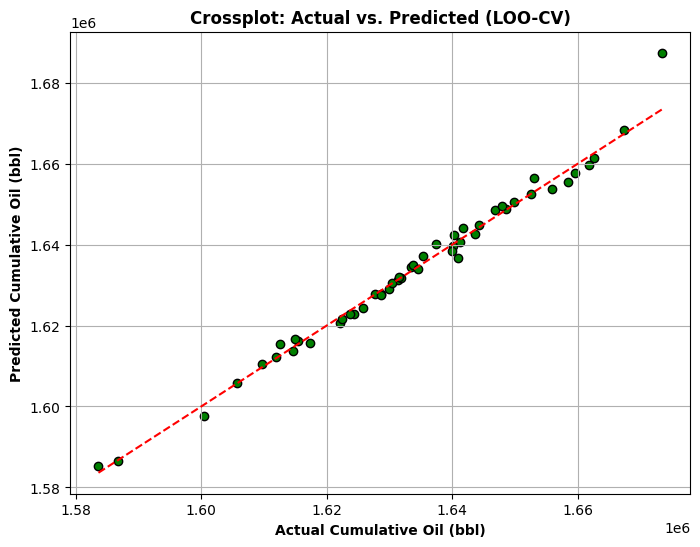

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from UQpy.distributions import Normal, JointIndependent
from UQpy.surrogates import PolynomialChaosExpansion, TotalDegreeBasis, LeastSquareRegression

# Step 1: Randomly sample 120 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data2 = df2.sample(n=50, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data2.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data2['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Define the maximum degree for the polynomial basis
max_degree = 3

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Actual': actual_values,
    'Predicted': predicted_values
})

# Step 10: Plot Actual vs. Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(loo_cv_results['Actual'], loo_cv_results['Predicted'], c='green', edgecolor='black')
plt.plot([min(loo_cv_results['Actual']), max(loo_cv_results['Actual'])],
         [min(loo_cv_results['Actual']), max(loo_cv_results['Actual'])],
         color='red', linestyle='--')  # 1:1 line
plt.xlabel('Actual Cumulative Oil (bbl)', fontweight='bold')
plt.ylabel('Predicted Cumulative Oil (bbl)', fontweight='bold')
plt.title('Crossplot: Actual vs. Predicted (LOO-CV)', fontweight='bold')
plt.grid(True)
plt.show()

___________

____

#**1092 SAMPLE**

In [ ]:
# Randomly sample 1500 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data = df2.sample(n=1092, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

In [ ]:
X.shape

(1092, 3)

In [ ]:
train_data.shape

(1092, 4)

In [ ]:
train_data.tail(10)

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil
2481,0.000005,1.058230,0.919973,1635905.8
8303,0.000005,1.218298,1.104029,1669036.6
3595,0.000005,1.071885,1.157905,1667570.8
11440,0.000004,0.935696,1.184535,1649774.8
10491,0.000004,0.910933,1.010517,1628229.3
2622,0.000004,0.935827,0.959812,1624984.5
14888,0.000005,0.830834,0.975231,1605838.4
6977,0.000005,1.094096,0.934249,1637932.6
7444,0.000003,0.929037,0.983630,1620193.5
5721,0.000004,0.958032,1.115057,1647911.5


In [ ]:
train_data.columns

Index(['CCPOR', 'PERMI_MULTI', 'POR_MULTI', 'Cum_Oil'], dtype='object')

In [ ]:
from UQpy.distributions import Uniform, Normal, JointIndependent
from UQpy.surrogates import *

In [ ]:
# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Generate samples
samples = joint_distribution.rvs(n_samples)

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

In [ ]:
# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Cum_Oil': actual_values,
    'Cum_Oil_PCE': predicted_values
})

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create polynomial basis using TotalDegreeBasis
polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

# Define the regression method
least_squares = LeastSquareRegression()

# Create the Polynomial Chaos Expansion (PCE) object
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

# Fit the PCE model to the input (x) and output (y) data
pce.fit(X, y)

In [ ]:
moments=pce.get_moments()
moments

(1623605.2794414465, 26683638120918.453)

In [ ]:
# Step 9: Perform Leave-One-Out Cross-Validation (LOO-CV) to assess the model
loo_error = pce.leaveoneout_error()

# Print the Leave-One-Out cross-validation error
print(f'Leave-One-Out Cross Validation Error (LOO-CV): {loo_error}')

Leave-One-Out Cross Validation Error (LOO-CV): 3.1297851


In [ ]:
# Get the remaining data that was not part of the sampled_1000
Test_Data = df2.drop(train_data.index)
# Prepare the feature matrix X_test and target vector y_test for the test set
X_test = Test_Data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column for testing features

y_test = pce.predict(X_test)

In [ ]:
# Add the predicted_y as a new column to the Z DataFrame
Test_Data['Cum_Oil_PCE'] = y_test

Test_Data.head()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil,Cum_Oil_PCE
0,0.000005,1.001000,1.001000,1641502.0,1.641630e+06
1,0.000004,1.047771,1.100369,1658139.5,1.658194e+06
2,0.000004,1.021748,0.986743,1638181.8,1.637391e+06
4,0.000005,0.893916,1.116380,1642039.0,1.642611e+06
5,0.000004,1.022663,1.018361,1643717.4,1.642656e+06


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

n_samples = len(Test_Data)

# Predict on training and test sets
y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

error = np.sum(np.abs((y_test - y_test_PCE)/y_test))/n_samples

print('Mean rel. error, LSTSQ:', error)

Mean rel. error, LSTSQ: 0.0019394327755689253


In [ ]:
import numpy as np

# Assuming y_test and y_test_PCE are defined from the previous code.

# Step 1: Calculate the variance of y_test
mean_y_test = np.mean(y_test)
variance_y_test = np.sum((y_test - mean_y_test) ** 2)

# Step 2: Calculate the squared differences between actual and predicted values
squared_differences = np.sum((y_test - y_test_PCE) ** 2)

# Step 3: Compute the empirical error as per the formula
empirical_error = squared_differences / variance_y_test

print('Empirical error (normalized by variance):', empirical_error)

Empirical error (normalized by variance): 1.8521498789128956


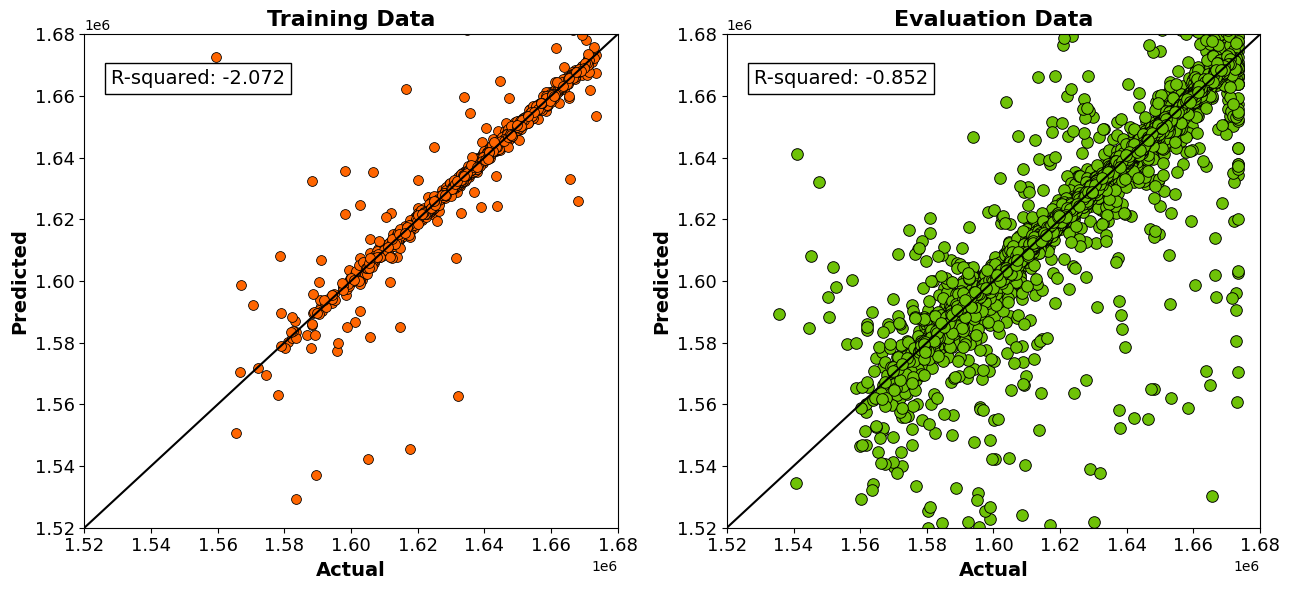

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Provided datasets
y_train = loo_cv_results['Cum_Oil']
y_train_PCE = loo_cv_results['Cum_Oil_PCE']

y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

# Set custom limits for both axes
x_min, x_max = 1.52e6, 1.68e6
y_min, y_max = 1.52e6, 1.68e6

# Calculate R-squared scores for training and test sets
train_r2 = r2_score(y_train, y_train_PCE)
test_r2 = r2_score(y_test, y_test_PCE)

# Create dataframes with the actual and predicted values for training and test sets
train_data1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_PCE})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_PCE})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training set
sns.scatterplot(data=train_data1, x='Actual', y='Predicted', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])

# Add grid line
#axes[0].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[0].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

# Add grid line
#axes[1].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[1].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score for test set as text inside the plot
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Crossplot 1092 Sample.png', dpi=300)
plt.show()

In [ ]:
train_data.shape

(1092, 4)

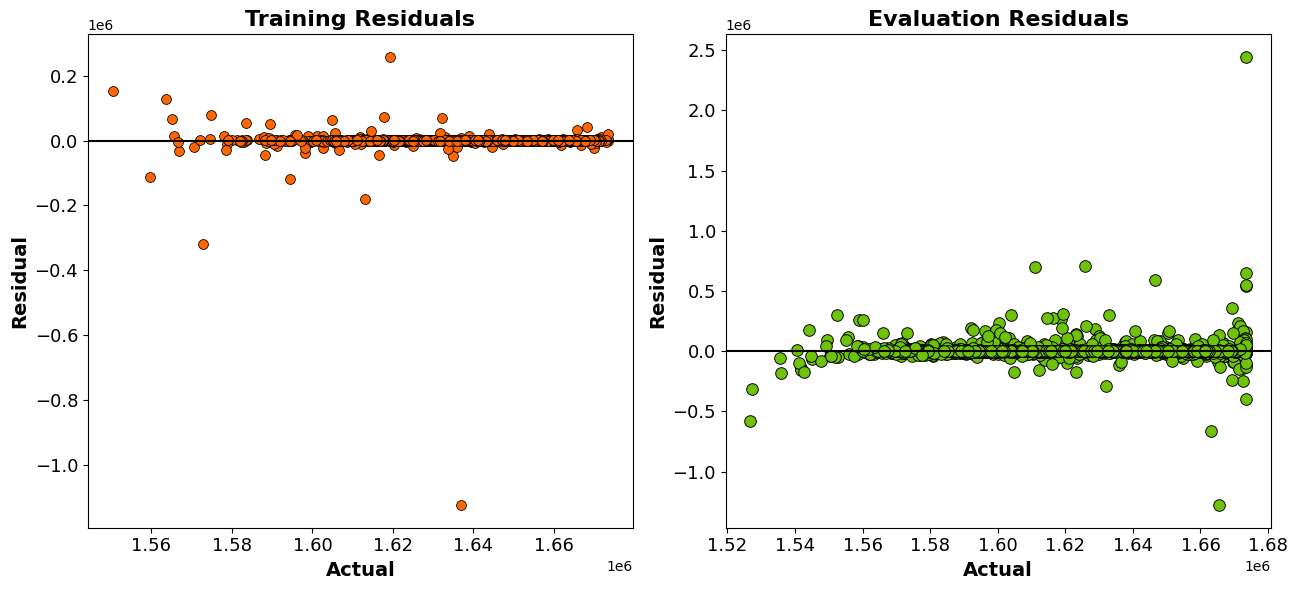

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Calculate residuals for training and test sets
train_residuals = y_train - y_train_PCE
test_residuals = y_test - y_test_PCE

# Create dataframes with the actual and residual values for training and test sets
train_data_residual = pd.DataFrame({'Actual': y_train, 'Residual': train_residuals})
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create separate plots for training and test residuals
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training residuals
sns.scatterplot(data=train_data_residual, x='Actual', y='Residual', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Residuals', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Residual', fontsize=14, fontweight='bold')

# Add grid line
#axes[0].grid(True)

# Add horizontal line at y=0 (no residuals)
axes[0].axhline(0, color='black', linestyle='-')

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Residual', fontsize=14, fontweight='bold')

# Add grid line
#axes[1].grid(True)

# Add horizontal line at y=0 (no residuals)
axes[1].axhline(0, color='black', linestyle='-')

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 1092 Sample.png', dpi=300)
plt.show()

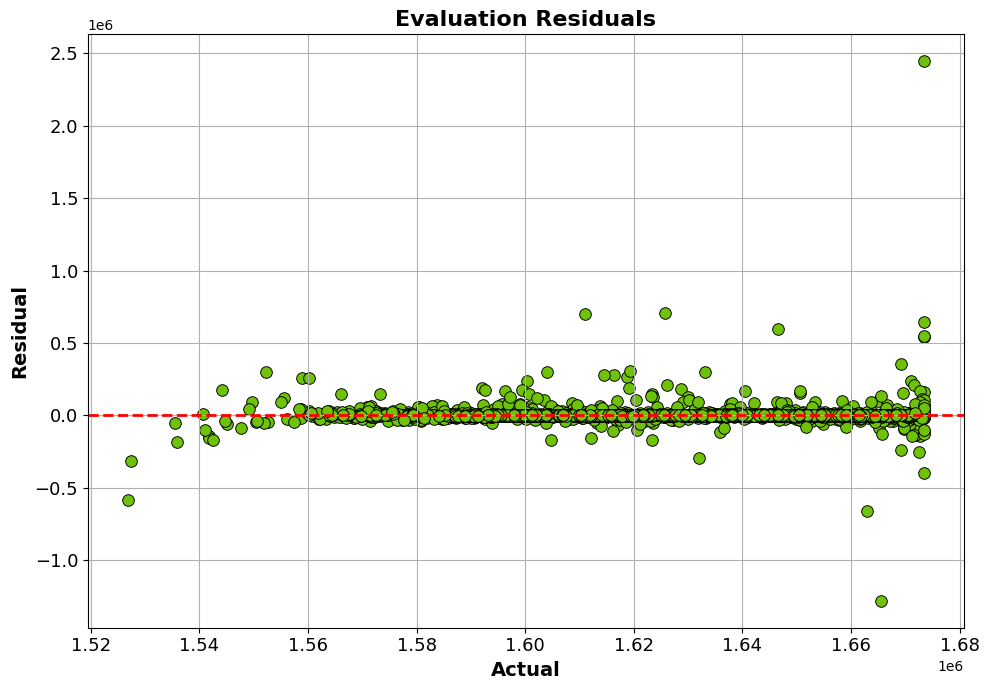

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate residuals for test set (evaluation data)
test_residuals = y_test - y_test_PCE

# Create a dataframe with the actual and residual values for test set
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create the residual plot for evaluation data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', s=70, color='#6EC207', edgecolor='black')
ax.set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
ax.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax.set_ylabel('Residual', fontsize=14, fontweight='bold')

# Add grid line (optional, uncomment to enable)
ax.grid(True)

# Add horizontal line at y=0 (no residuals)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# Adjust tick label size and bold
ax.tick_params(axis='x', labelsize=13, labelcolor='black')
ax.tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 1092 Sample.png', dpi=300)
plt.show()

In [ ]:
Test_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15985 entries, 0 to 17076
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CCPOR        15985 non-null  float64
 1   PERMI_MULTI  15985 non-null  float64
 2   POR_MULTI    15985 non-null  float64
 3   Cum_Oil      15985 non-null  float64
 4   Cum_Oil_PCE  15985 non-null  float64
dtypes: float64(5)
memory usage: 749.3 KB


In [ ]:
from scipy.stats import zscore

# Step 1: Calculate residuals for test set (evaluation data)
residuals = y_test - y_test_PCE

# Step 2: Calculate Z-scores for the residuals
z_scores = zscore(residuals)

# Step 3: Detect points where |Z| > 3 (outliers)
outliers = abs(z_scores) > 3

# Step 4: Make sure the boolean mask aligns with the index of Test_Data
# Convert to DataFrame to ensure proper alignment
outliers_data = Test_Data[outliers]

# Step 5: Show the outliers
print("Outliers detected:", outliers.sum())
print(outliers_data[['Cum_Oil', 'Cum_Oil_PCE']])

Outliers detected: 89
         Cum_Oil   Cum_Oil_PCE
17     1671130.0  1.433918e+06
93     1552293.0  1.250648e+06
172    1526802.6  2.108845e+06
205    1665436.5  2.945695e+06
873    1665002.9  1.566272e+06
...          ...           ...
16370  1631843.1  1.537706e+06
16623  1616179.5  1.722028e+06
16898  1566127.0  1.419084e+06
16943  1669627.6  1.515670e+06
17050  1573173.4  1.422793e+06

[89 rows x 2 columns]


In [ ]:
Test_Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15985 entries, 0 to 17076
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CCPOR        15985 non-null  float64
 1   PERMI_MULTI  15985 non-null  float64
 2   POR_MULTI    15985 non-null  float64
 3   Cum_Oil      15985 non-null  float64
 4   Cum_Oil_PCE  15985 non-null  float64
dtypes: float64(5)
memory usage: 749.3 KB


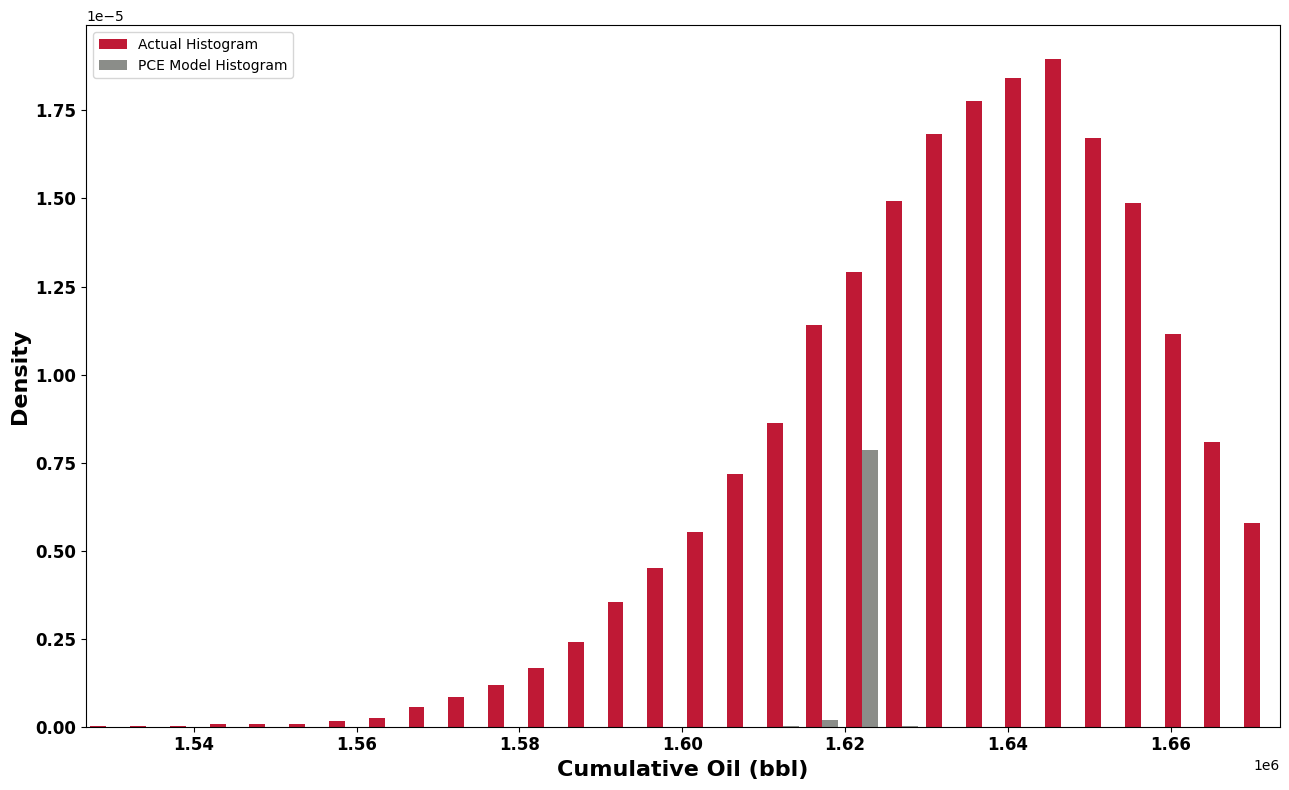

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Test_Data3' is your dataset. Uncomment and replace it with your actual data loading method
# Test_Data3 = pd.read_csv('your_data_file.csv')

# Number of bins
bins = 30

# Compute histograms manually
hist1, bin_edges = np.histogram(Test_Data['Cum_Oil'], bins=bins, density=True)
hist2, _ = np.histogram(Test_Data['Cum_Oil_PCE'], bins=bins, density=True)

# Width of each bar
bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # Adjust width to make sure they fit side by side

# Shift the bar positions for the second histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bar_shift = bar_width / 2

# Plotting the histograms of Cumulative Oil and Cumulative Oil PCE side by side
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the first histogram
plt.bar(bin_centers - bar_shift, hist1, width=bar_width, color="#B8001F", label='Actual Histogram', alpha=0.9)

# Plot the second histogram
plt.bar(bin_centers + bar_shift, hist2, width=bar_width, color='#181C14', label='PCE Model Histogram', alpha=0.5)

# Set the font size for x and y axis labels and title
plt.xlabel('Cumulative Oil (bbl)', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')  # Set x-tick properties
plt.yticks(fontsize=12, fontweight='bold')  # Set y-tick properties

# Add a legend in the upper-left position
plt.legend(loc='upper left')

# Add grid
plt.grid(False)

# Set the X-axis limits to the min and max values of 'Cum_Oil_PCE'
plt.xlim([Test_Data['Cum_Oil'].min(), Test_Data['Cum_Oil'].max()])

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Histogram 1092 Sample.png', dpi=300)
plt.show()

In [ ]:
# Calculate the P90, P50, and P10

# Calculate the P90, P50, and P10
p90 = np.percentile(df2['Cum_Oil'], 10)
p50 = np.percentile(df2['Cum_Oil'], 50)
p10 = np.percentile(df2['Cum_Oil'], 90)


p90_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 10)
p50_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 50)
p10_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 90)

# Print the results
print(f"P90: {p90}")
print(f"P50: {p50}")
print(f"P10: {p10}")

# Print the results
print(f"P90_PCE: {p90_PCE}")
print(f"P50_PCE: {p50_PCE}")
print(f"P10_PCE: {p10_PCE}")

P90: 1604672.0999999999
P50: 1636815.6
P10: 1660732.04
P90_PCE: 1603867.6262255134
P50_PCE: 1636782.3576158471
P10_PCE: 1660541.0623688393


__________

_________

#**1456 SAMPLE**

In [ ]:
# Randomly sample 1500 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data2 = df2.sample(n=1456, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data2.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data2['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

In [ ]:
X.shape

(1456, 3)

In [ ]:
# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Generate samples
samples = joint_distribution.rvs(n_samples)

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

In [ ]:
# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Cum_Oil': actual_values,
    'Cum_Oil_PCE': predicted_values
})

loo_cv_results.head()

,Cum_Oil,Cum_Oil_PCE
0,1631329.4,1.631990e+06
1,1643635.1,1.641982e+06
2,1673400.0,1.671538e+06
3,1667256.5,1.668869e+06
4,1633459.4,1.633553e+06


In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create polynomial basis using TotalDegreeBasis
polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

# Define the regression method
least_squares = LeastSquareRegression()

# Create the Polynomial Chaos Expansion (PCE) object
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

# Fit the PCE model to the input (x) and output (y) data
pce.fit(X, y)

In [ ]:
moments=pce.get_moments()
moments

(1612997.945752161, 6855556090978.832)

In [ ]:
# Step 9: Perform Leave-One-Out Cross-Validation (LOO-CV) to assess the model
loo_error = pce.leaveoneout_error()

# Print the Leave-One-Out cross-validation error
print(f'Leave-One-Out Cross Validation Error (LOO-CV): {loo_error}')

Leave-One-Out Cross Validation Error (LOO-CV): 0.1110874


In [ ]:
# Get the remaining data that was not part of the sampled_1000
Test_Data = df2.drop(train_data2.index)
# Prepare the feature matrix X_test and target vector y_test for the test set
X_test = Test_Data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column for testing features

y_test = pce.predict(X_test)

In [ ]:
# Add the predicted_y as a new column to the Z DataFrame
Test_Data['Cum_Oil_PCE'] = y_test

Test_Data.head()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil,Cum_Oil_PCE
0,0.000005,1.001000,1.001000,1641502.0,1.641651e+06
1,0.000004,1.047771,1.100369,1658139.5,1.658096e+06
2,0.000004,1.021748,0.986743,1638181.8,1.637345e+06
4,0.000005,0.893916,1.116380,1642039.0,1.641862e+06
5,0.000004,1.022663,1.018361,1643717.4,1.642394e+06


In [ ]:
Test_Data.shape

(15621, 5)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

n_samples = len(Test_Data)

# Predict on training and test sets
y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

error = np.sum(np.abs((y_test - y_test_PCE)/y_test))/n_samples

print('Mean rel. error, LSTSQ:', error)

Mean rel. error, LSTSQ: 0.0014426996456024215


In [ ]:
# Assuming y_test and y_test_PCE are defined from the previous code.

# Step 1: Calculate the variance of y_test
mean_y_test = np.mean(y_test)
variance_y_test = np.sum((y_test - mean_y_test) ** 2)

# Step 2: Calculate the squared differences between actual and predicted values
squared_differences = np.sum((y_test - y_test_PCE) ** 2)

# Step 3: Compute the empirical error as per the formula
empirical_error = squared_differences / variance_y_test

print('Empirical error (normalized by variance):', empirical_error)

Empirical error (normalized by variance): 0.9476869113022094


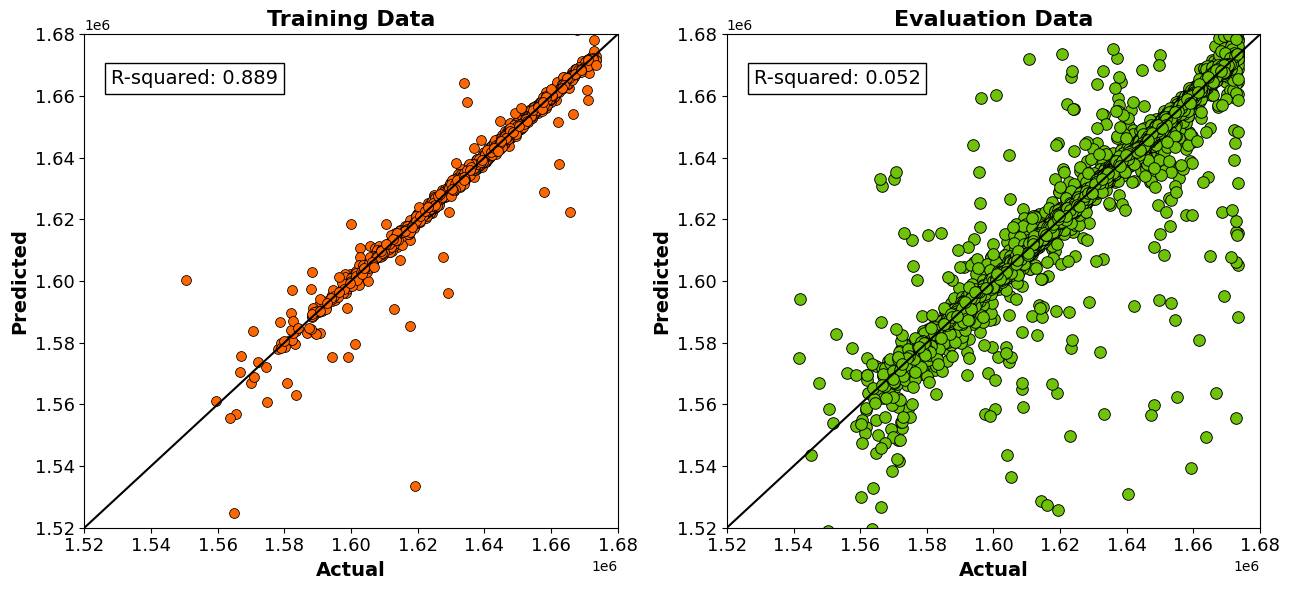

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Provided datasets
y_train = loo_cv_results['Cum_Oil']
y_train_PCE = loo_cv_results['Cum_Oil_PCE']

y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

# Set custom limits for both axes
x_min, x_max = 1.52e6, 1.68e6
y_min, y_max = 1.52e6, 1.68e6

# Calculate R-squared scores for training and test sets
train_r2 = r2_score(y_train, y_train_PCE)
test_r2 = r2_score(y_test, y_test_PCE)

# Create dataframes with the actual and predicted values for training and test sets
train_data1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_PCE})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_PCE})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training set
sns.scatterplot(data=train_data1, x='Actual', y='Predicted', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])

# Add grid line
#axes[0].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[0].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

# Add grid line
#axes[1].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[1].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score for test set as text inside the plot
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Crossplot 1456 Sample.png', dpi=300)
plt.show()

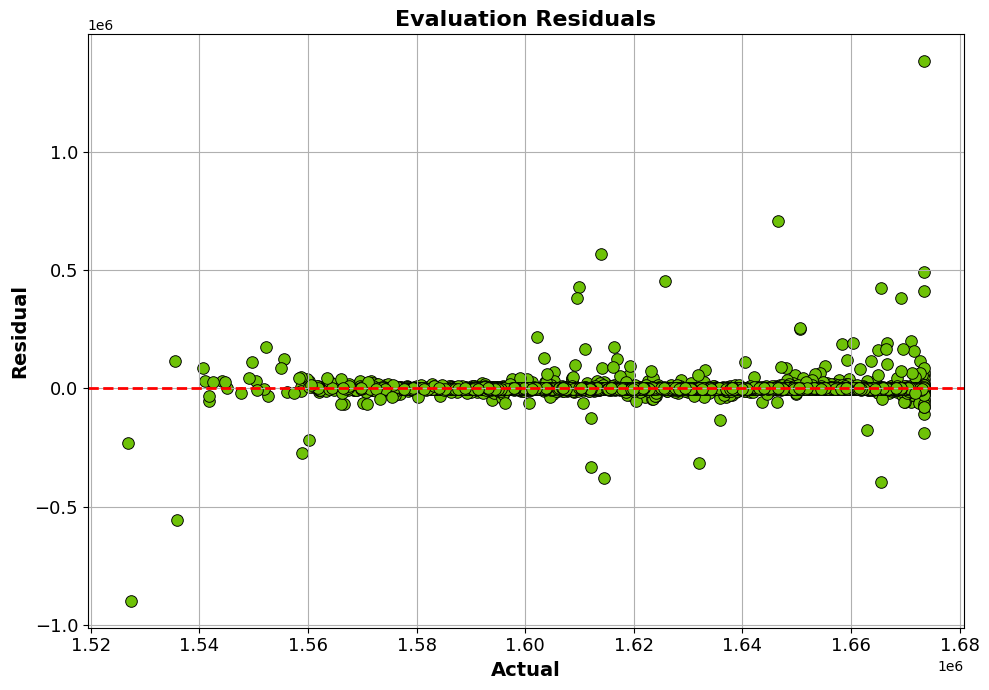

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate residuals for test set (evaluation data)
test_residuals = y_test - y_test_PCE

# Create a dataframe with the actual and residual values for test set
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create the residual plot for evaluation data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', s=70, color='#6EC207', edgecolor='black')
ax.set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
ax.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax.set_ylabel('Residual', fontsize=14, fontweight='bold')

# Add grid line (optional, uncomment to enable)
ax.grid(True)

# Add horizontal line at y=0 (no residuals)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# Adjust tick label size and bold
ax.tick_params(axis='x', labelsize=13, labelcolor='black')
ax.tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 1456 Sample.png', dpi=300)
plt.show()

In [ ]:
from scipy.stats import zscore

# Step 1: Calculate residuals for test set (evaluation data)
residuals = y_test - y_test_PCE

# Step 2: Calculate Z-scores for the residuals
z_scores = zscore(residuals)

# Step 3: Detect points where |Z| > 3 (outliers)
outliers = abs(z_scores) > 3

# Step 4: Make sure the boolean mask aligns with the index of Test_Data
# Convert to DataFrame to ensure proper alignment
outliers_data = Test_Data[outliers]

# Step 5: Show the outliers
print("Outliers detected:", outliers.sum())
print(outliers_data[['Cum_Oil', 'Cum_Oil_PCE']])

Outliers detected: 73
         Cum_Oil   Cum_Oil_PCE
17     1671130.0  1.471941e+06
93     1552293.0  1.378611e+06
172    1526802.6  1.756630e+06
205    1665436.5  2.060416e+06
403    1609190.6  1.510406e+06
...          ...           ...
16411  1673400.0  1.753333e+06
16623  1616179.5  1.527284e+06
16756  1612059.3  1.735311e+06
16781  1609574.5  1.226069e+06
16943  1669627.6  1.504287e+06

[73 rows x 2 columns]


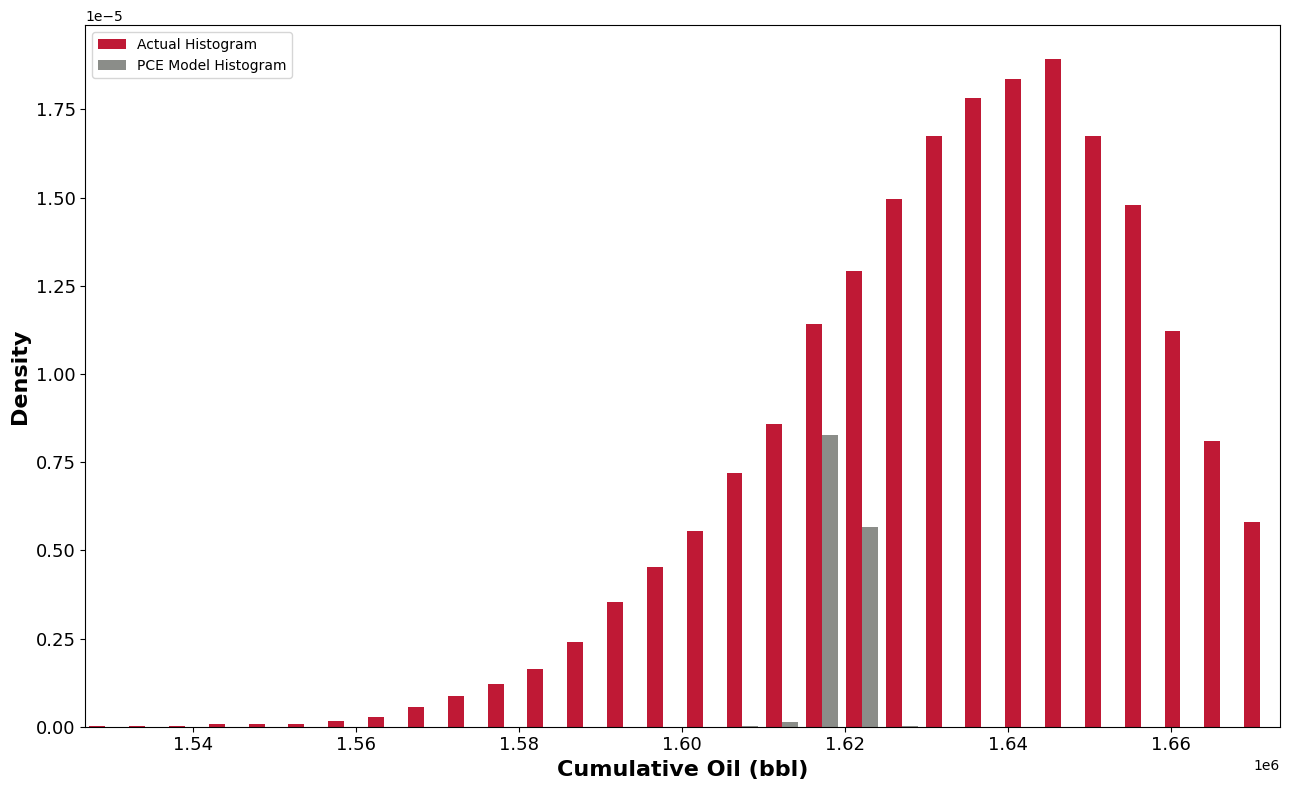

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Test_Data3' is your dataset. Uncomment and replace it with your actual data loading method
# Test_Data3 = pd.read_csv('your_data_file.csv')

# Number of bins
bins = 30

# Compute histograms manually
hist1, bin_edges = np.histogram(Test_Data['Cum_Oil'], bins=bins, density=True)
hist2, _ = np.histogram(Test_Data['Cum_Oil_PCE'], bins=bins, density=True)

# Width of each bar
bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # Adjust width to make sure they fit side by side

# Shift the bar positions for the second histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bar_shift = bar_width / 2

# Plotting the histograms of Cumulative Oil and Cumulative Oil PCE side by side
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the first histogram
plt.bar(bin_centers - bar_shift, hist1, width=bar_width, color="#B8001F", label='Actual Histogram', alpha=0.9)

# Plot the second histogram
plt.bar(bin_centers + bar_shift, hist2, width=bar_width, color='#181C14', label='PCE Model Histogram', alpha=0.5)

# Set the font size for x and y axis labels and title
plt.xlabel('Cumulative Oil (bbl)', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # Set x-tick properties
plt.yticks(fontsize=13)  # Set y-tick properties

# Add a legend in the upper-left position
plt.legend(loc='upper left')

# Add grid
plt.grid(False)

# Set the X-axis limits to the min and max values of 'Cum_Oil_PCE'
plt.xlim([Test_Data['Cum_Oil'].min(), Test_Data['Cum_Oil'].max()])

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Histogram 1456 Sample.png', dpi=300)
plt.show()

In [ ]:
# Calculate the P90, P50, and P10

# Calculate the P90, P50, and P10
p90 = np.percentile(df2['Cum_Oil'], 10)
p50 = np.percentile(df2['Cum_Oil'], 50)
p10 = np.percentile(df2['Cum_Oil'], 90)


p90_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 10)
p50_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 50)
p10_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 90)

# Print the results
print(f"P90: {p90}")
print(f"P50: {p50}")
print(f"P10: {p10}")

# Print the results
print(f"P90_PCE: {p90_PCE}")
print(f"P50_PCE: {p50_PCE}")
print(f"P10_PCE: {p10_PCE}")

P90: 1604672.0999999999
P50: 1636815.6
P10: 1660732.04
P90_PCE: 1604273.4797334305
P50_PCE: 1636815.0804448323
P10_PCE: 1660587.5428473386


__________

_______

#**1100 SAMPLE**

In [ ]:
# Randomly sample 1500 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data3 = df2.sample(n=1820, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data3.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data3['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

In [ ]:
X.shape

(1820, 3)

In [ ]:
# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Generate samples
samples = joint_distribution.rvs(n_samples)

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

In [ ]:
# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Cum_Oil': actual_values,
    'Cum_Oil_PCE': predicted_values
})

loo_cv_results.head()

,Cum_Oil,Cum_Oil_PCE
0,1631329.4,1.632188e+06
1,1643635.1,1.642114e+06
2,1673400.0,1.674240e+06
3,1667256.5,1.668029e+06
4,1633459.4,1.633622e+06


In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create polynomial basis using TotalDegreeBasis
polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

# Define the regression method
least_squares = LeastSquareRegression()

# Create the Polynomial Chaos Expansion (PCE) object
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

# Fit the PCE model to the input (x) and output (y) data
pce.fit(X, y)

In [ ]:
moments=pce.get_moments()
moments

(1625378.6253356661, 2023877505858.8306)

In [ ]:
# Step 9: Perform Leave-One-Out Cross-Validation (LOO-CV) to assess the model
loo_error = pce.leaveoneout_error()

# Print the Leave-One-Out cross-validation error
print(f'Leave-One-Out Cross Validation Error (LOO-CV): {loo_error}')

Leave-One-Out Cross Validation Error (LOO-CV): 0.250828


In [ ]:
# Get the remaining data that was not part of the sampled_1000
Test_Data = df2.drop(train_data3.index)
# Prepare the feature matrix X_test and target vector y_test for the test set
X_test = Test_Data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column for testing features

y_test = pce.predict(X_test)

In [ ]:
Test_Data.shape

(15257, 4)

In [ ]:
# Add the predicted_y as a new column to the Z DataFrame
Test_Data['Cum_Oil_PCE'] = y_test

Test_Data.head()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil,Cum_Oil_PCE
0,0.000005,1.001000,1.001000,1641502.0,1.641542e+06
1,0.000004,1.047771,1.100369,1658139.5,1.657769e+06
2,0.000004,1.021748,0.986743,1638181.8,1.637416e+06
4,0.000005,0.893916,1.116380,1642039.0,1.641720e+06
5,0.000004,1.022663,1.018361,1643717.4,1.642650e+06


In [ ]:
Test_Data.shape

(15257, 5)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

n_samples = len(Test_Data)

# Predict on training and test sets
y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

error = np.sum(np.abs((y_test - y_test_PCE)/y_test))/n_samples

print('Mean rel. error, LSTSQ:', error)

Mean rel. error, LSTSQ: 0.0007405098857661463


In [ ]:
import numpy as np

# Assuming y_test and y_test_PCE are defined from the previous code.

# Step 1: Calculate the variance of y_test
mean_y_test = np.mean(y_test)
variance_y_test = np.sum((y_test - mean_y_test) ** 2)

# Step 2: Calculate the squared differences between actual and predicted values
squared_differences = np.sum((y_test - y_test_PCE) ** 2)

# Step 3: Compute the empirical error as per the formula
empirical_error = squared_differences / variance_y_test

print('Empirical error (normalized by variance):', empirical_error)

Empirical error (normalized by variance): 0.15642058217436294


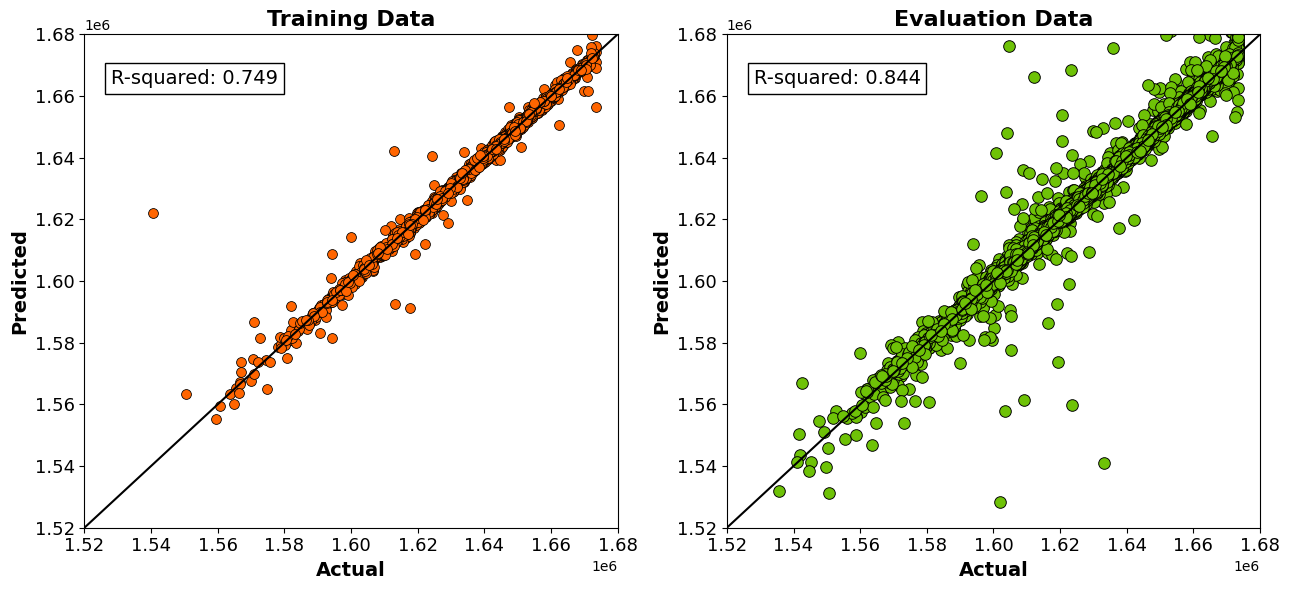

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Provided datasets
y_train = loo_cv_results['Cum_Oil']
y_train_PCE = loo_cv_results['Cum_Oil_PCE']

y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

# Set custom limits for both axes
x_min, x_max = 1.52e6, 1.68e6
y_min, y_max = 1.52e6, 1.68e6

# Calculate R-squared scores for training and test sets
train_r2 = r2_score(y_train, y_train_PCE)
test_r2 = r2_score(y_test, y_test_PCE)

# Create dataframes with the actual and predicted values for training and test sets
train_data1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_PCE})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_PCE})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training set
sns.scatterplot(data=train_data1, x='Actual', y='Predicted', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])

# Add grid line
#axes[0].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[0].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

# Add grid line
#axes[1].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[1].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score for test set as text inside the plot
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Crossplot 1820 Sample.png', dpi=300)
plt.show()

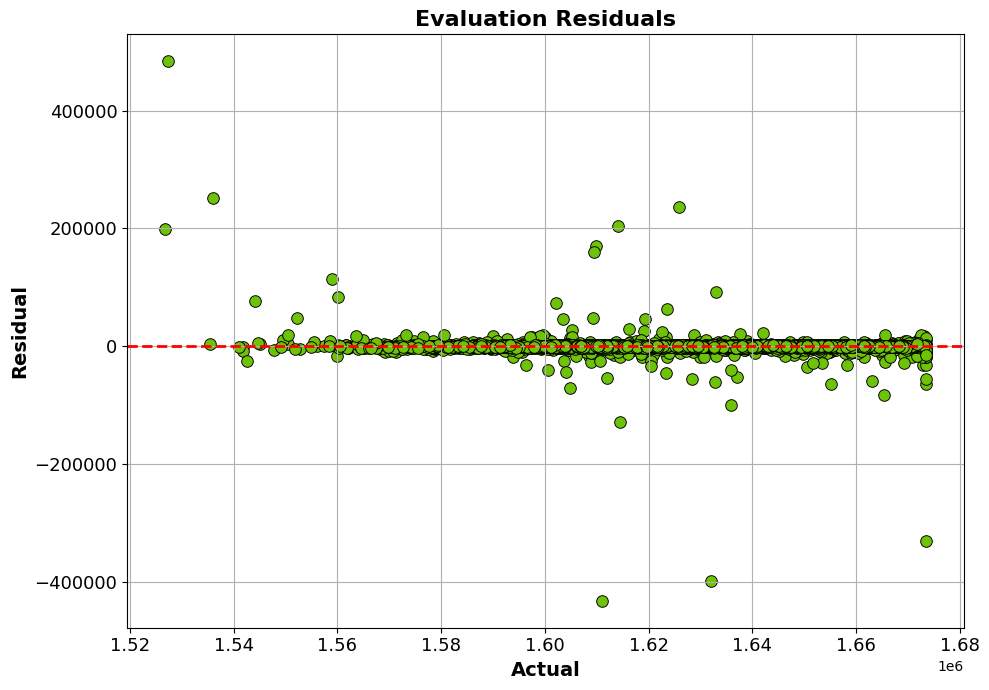

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate residuals for test set (evaluation data)
test_residuals = y_test - y_test_PCE

# Create a dataframe with the actual and residual values for test set
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create the residual plot for evaluation data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', s=70, color='#6EC207', edgecolor='black')
ax.set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
ax.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax.set_ylabel('Residual', fontsize=14, fontweight='bold')

# Add grid line (optional, uncomment to enable)
ax.grid(True)

# Add horizontal line at y=0 (no residuals)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# Adjust tick label size and bold
ax.tick_params(axis='x', labelsize=13, labelcolor='black')
ax.tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 1820 Sample.png', dpi=300)
plt.show()

In [ ]:
from scipy.stats import zscore

# Step 1: Calculate residuals for test set (evaluation data)
residuals = y_test - y_test_PCE

# Step 2: Calculate Z-scores for the residuals
z_scores = zscore(residuals)

# Step 3: Detect points where |Z| > 3 (outliers)
outliers = abs(z_scores) > 3

# Step 4: Make sure the boolean mask aligns with the index of Test_Data
# Convert to DataFrame to ensure proper alignment
outliers_data = Test_Data[outliers]

# Step 5: Show the outliers
print("Outliers detected:", outliers.sum())
print(outliers_data[['Cum_Oil', 'Cum_Oil_PCE']])

Outliers detected: 50
         Cum_Oil   Cum_Oil_PCE
93     1552293.0  1.503944e+06
172    1526802.6  1.327478e+06
205    1665436.5  1.747937e+06
403    1609190.6  1.561575e+06
648    1609837.8  1.439651e+06
975    1604783.5  1.676156e+06
1341   1605281.3  1.577684e+06
1469   1658294.5  1.690386e+06
2357   1558957.9  1.445220e+06
3077   1560100.4  1.475674e+06
3174   1633049.3  1.540833e+06
3800   1608899.4  1.636114e+06
4377   1623546.8  1.559700e+06
4559   1672831.4  1.703830e+06
4619   1527383.4  1.043752e+06
5117   1623304.1  1.668373e+06
5609   1673400.0  1.737509e+06
5730   1611015.5  2.042761e+06
6010   1636981.3  1.689221e+06
6364   1673400.0  1.705411e+06
6845   1655159.8  1.719508e+06
6996   1614022.1  1.410038e+06
7259   1603453.9  1.557898e+06
8470   1662996.1  1.722201e+06
9373   1544166.9  1.467316e+06
9448   1650526.3  1.686383e+06
9702   1635809.4  1.734896e+06
10006  1635808.3  1.675493e+06
10023  1673400.0  1.728907e+06
10575  1616300.3  1.586387e+06
10772  1653418.4 

In [ ]:
train_data3.shape

(1820, 4)

In [ ]:
Test_Data.shape

(15257, 5)

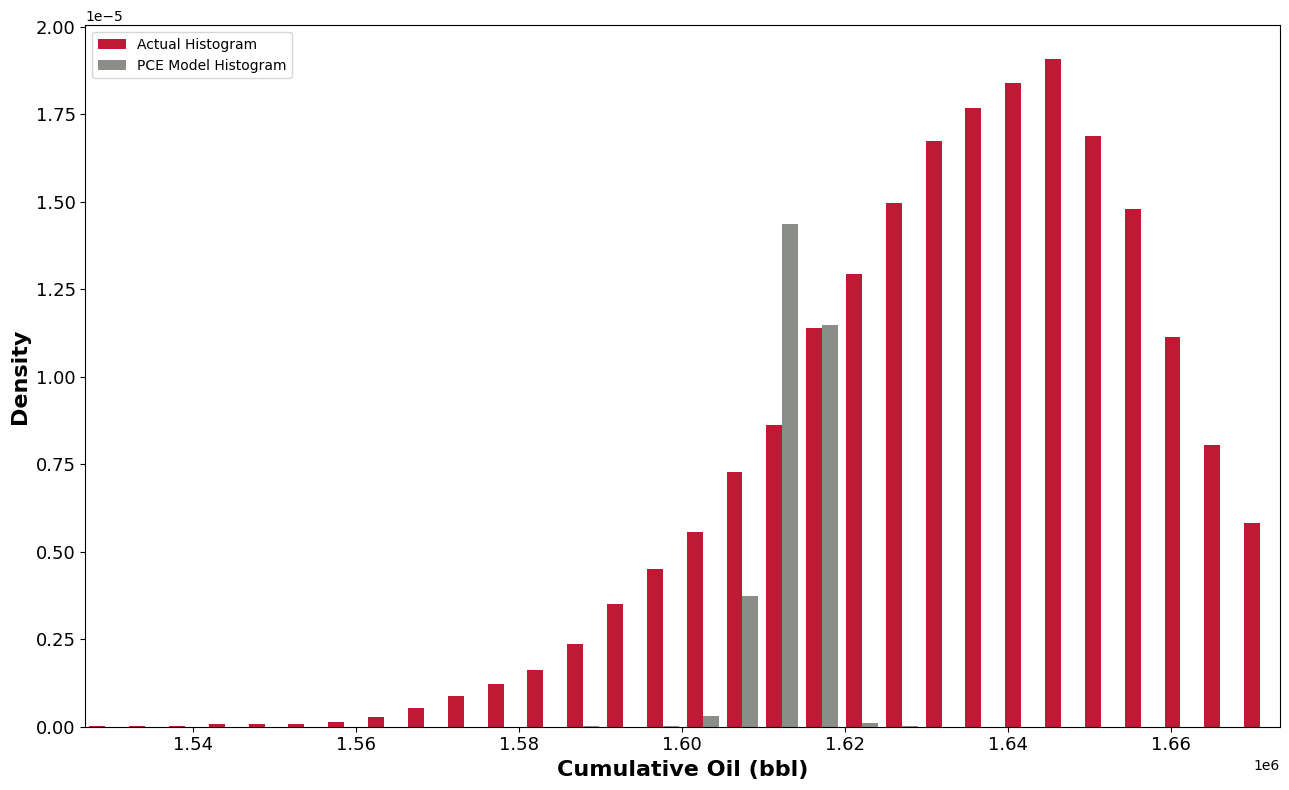

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Test_Data3' is your dataset. Uncomment and replace it with your actual data loading method
# Test_Data3 = pd.read_csv('your_data_file.csv')

# Number of bins
bins = 30

# Compute histograms manually
hist1, bin_edges = np.histogram(Test_Data['Cum_Oil'], bins=bins, density=True)
hist2, _ = np.histogram(Test_Data['Cum_Oil_PCE'], bins=bins, density=True)

# Width of each bar
bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # Adjust width to make sure they fit side by side

# Shift the bar positions for the second histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bar_shift = bar_width / 2

# Plotting the histograms of Cumulative Oil and Cumulative Oil PCE side by side
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the first histogram
plt.bar(bin_centers - bar_shift, hist1, width=bar_width, color="#B8001F", label='Actual Histogram', alpha=0.9)

# Plot the second histogram
plt.bar(bin_centers + bar_shift, hist2, width=bar_width, color='#181C14', label='PCE Model Histogram', alpha=0.5)

# Set the font size for x and y axis labels and title
plt.xlabel('Cumulative Oil (bbl)', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # Set x-tick properties
plt.yticks(fontsize=13)  # Set y-tick properties

# Add a legend in the upper-left position
plt.legend(loc='upper left')

# Add grid
plt.grid(False)

# Set the X-axis limits to the min and max values of 'Cum_Oil_PCE'
plt.xlim([Test_Data['Cum_Oil'].min(), Test_Data['Cum_Oil'].max()])

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Histogram 1820 Sample.png', dpi=300)
plt.show()

In [ ]:
# Calculate the P90, P50, and P10

# Calculate the P90, P50, and P10
p90 = np.percentile(df2['Cum_Oil'], 10)
p50 = np.percentile(df2['Cum_Oil'], 50)
p10 = np.percentile(df2['Cum_Oil'], 90)


p90_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 10)
p50_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 50)
p10_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 90)

# Print the results
print(f"P90: {p90}")
print(f"P50: {p50}")
print(f"P10: {p10}")

# Print the results
print(f"P90_PCE: {p90_PCE}")
print(f"P50_PCE: {p50_PCE}")
print(f"P10_PCE: {p10_PCE}")

P90: 1604672.0999999999
P50: 1636815.6
P10: 1660732.04
P90_PCE: 1604891.4455989553
P50_PCE: 1636952.5187656465
P10_PCE: 1660784.6118698006


___________

___________

#**1320 SAMPLE**

In [ ]:
# Randomly sample 1500 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data4 = df2.sample(n=2184, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data4.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data4['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

In [ ]:
X.shape

(2184, 3)

In [ ]:
# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Generate samples
samples = joint_distribution.rvs(n_samples)

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

In [ ]:
# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Cum_Oil': actual_values,
    'Cum_Oil_PCE': predicted_values
})

loo_cv_results.head()

,Cum_Oil,Cum_Oil_PCE
0,1631329.4,1.632030e+06
1,1643635.1,1.642219e+06
2,1673400.0,1.673688e+06
3,1667256.5,1.667992e+06
4,1633459.4,1.633600e+06


In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create a polynomial basis using TotalDegreeBasis
polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

# Define the regression method
least_squares = LeastSquareRegression()

# Create the Polynomial Chaos Expansion (PCE) object
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

# Fit the PCE model to the input (x) and output (y) data
pce.fit(X, y)

In [ ]:
moments=pce.get_moments()
moments

(1629191.277136615, 1150091386518.666)

In [ ]:
# Step 9: Perform Leave-One-Out Cross-Validation (LOO-CV) to assess the model
loo_error = pce.leaveoneout_error()

# Print the Leave-One-Out cross-validation error
print(f'Leave-One-Out Cross Validation Error (LOO-CV): {loo_error}')

Leave-One-Out Cross Validation Error (LOO-CV): 0.1469128


In [ ]:
# Get the remaining data that was not part of the sampled_1000
Test_Data = df2.drop(train_data4.index)
# Prepare the feature matrix X_test and target vector y_test for the test set
X_test = Test_Data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column for testing features

y_test = pce.predict(X_test)

In [ ]:
# Add the predicted_y as a new column to the Z DataFrame
Test_Data['Cum_Oil_PCE'] = y_test

Test_Data.head()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil,Cum_Oil_PCE
0,0.000005,1.001000,1.001000,1641502.0,1.641454e+06
1,0.000004,1.047771,1.100369,1658139.5,1.657892e+06
2,0.000004,1.021748,0.986743,1638181.8,1.637468e+06
4,0.000005,0.893916,1.116380,1642039.0,1.641695e+06
5,0.000004,1.022663,1.018361,1643717.4,1.642761e+06


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

n_samples = len(Test_Data)

# Predict on training and test sets
y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

error = np.sum(np.abs((y_test - y_test_PCE)/y_test))/n_samples

print('Mean rel. error, LSTSQ:', error)

Mean rel. error, LSTSQ: 0.0006477228473128319


In [ ]:
import numpy as np

# Assuming y_test and y_test_PCE are defined from the previous code.

# Step 1: Calculate the variance of y_test
mean_y_test = np.mean(y_test)
variance_y_test = np.sum((y_test - mean_y_test) ** 2)

# Step 2: Calculate the squared differences between actual and predicted values
squared_differences = np.sum((y_test - y_test_PCE) ** 2)

# Step 3: Compute the empirical error as per the formula
empirical_error = squared_differences / variance_y_test

print('Empirical error (normalized by variance):', empirical_error)

Empirical error (normalized by variance): 0.11719357978619141


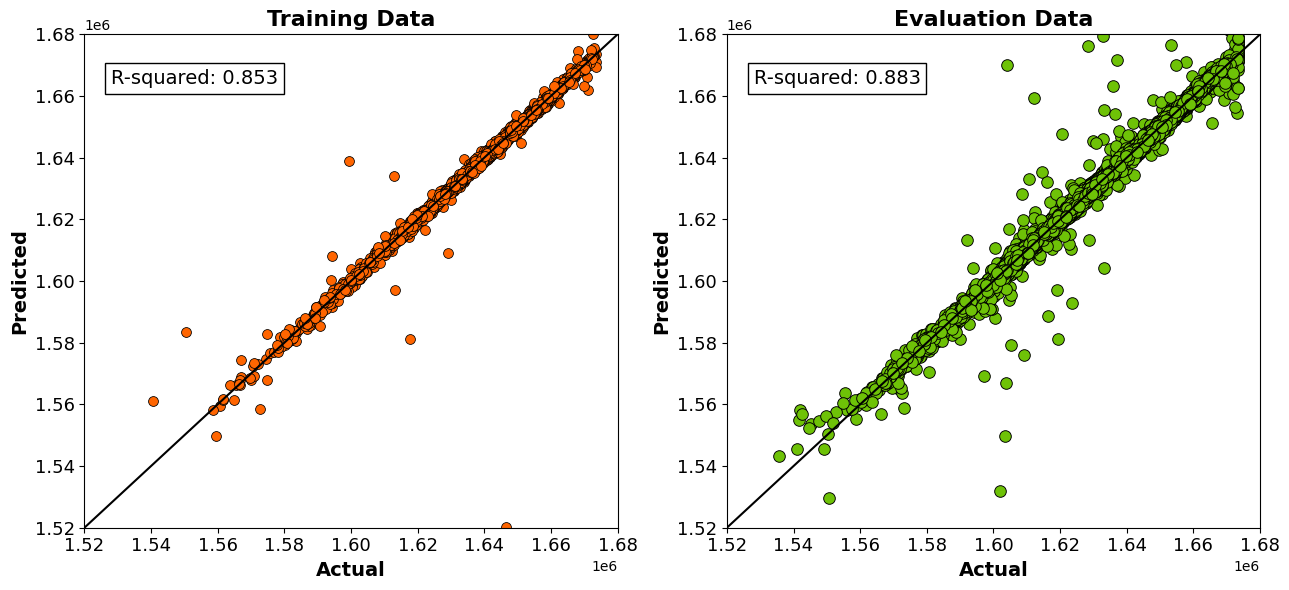

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Provided datasets
y_train = loo_cv_results['Cum_Oil']
y_train_PCE = loo_cv_results['Cum_Oil_PCE']

y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

# Set custom limits for both axes
x_min, x_max = 1.52e6, 1.68e6
y_min, y_max = 1.52e6, 1.68e6

# Calculate R-squared scores for training and test sets
train_r2 = r2_score(y_train, y_train_PCE)
test_r2 = r2_score(y_test, y_test_PCE)

# Create dataframes with the actual and predicted values for training and test sets
train_data1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_PCE})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_PCE})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training set
sns.scatterplot(data=train_data1, x='Actual', y='Predicted', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])

# Add grid line
#axes[0].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[0].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

# Add grid line
#axes[1].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[1].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score for test set as text inside the plot
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Crossplot 2184 Sample.png', dpi=300)
plt.show()

In [ ]:
print("Variance of Actual (Train):", np.var(y_train))
print("Variance of Predicted (Train):", np.var(y_train_PCE))

print("Variance of Actual (Test):", np.var(y_test))
print("Variance of Predicted (Test):", np.var(y_test_PCE))

Variance of Actual (Train): 487001039.5071715
Variance of Predicted (Train): 555079275.505811
Variance of Actual (Test): 469174658.79490155
Variance of Predicted (Test): 538924693.0421301


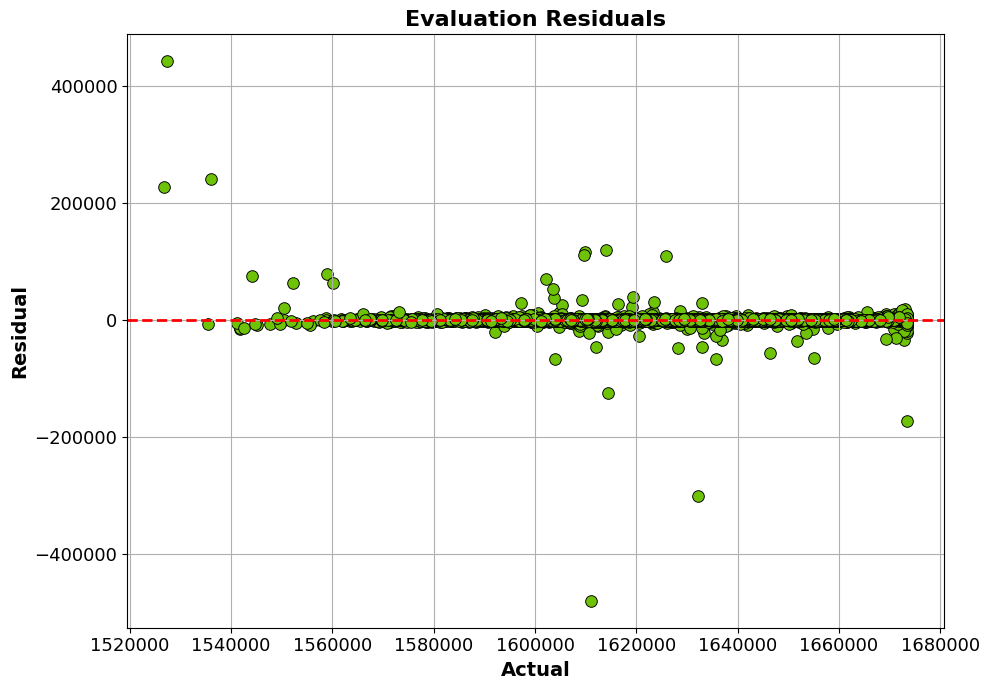

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter

# Calculate residuals for test set (evaluation data)
test_residuals = y_test - y_test_PCE

# Create a dataframe with the actual and residual values for test set
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create the residual plot for evaluation data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', s=70, color='#6EC207', edgecolor='black')
ax.set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
ax.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax.set_ylabel('Residual', fontsize=14, fontweight='bold')

# Turn off scientific notation for both axes
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().set_major_formatter(ScalarFormatter(useMathText=False))
ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=False))

# Add grid line for better clarity
ax.grid(True)

# Add horizontal line at y=0 (no residuals)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# Adjust tick label size and bold
ax.tick_params(axis='x', labelsize=13, labelcolor='black')
ax.tick_params(axis='y', labelsize=13, labelcolor='black')

# Adjust the tick formatting style to plain (no scientific notation)
ax.ticklabel_format(style='plain')

plt.tight_layout()

# Save the figure (optional, uncomment to save)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 2184 Sample.png', dpi=300)

# Display the plot
plt.show()

In [ ]:
from scipy.stats import zscore

# Step 1: Calculate residuals for test set (evaluation data)
residuals = y_test - y_test_PCE

# Step 2: Calculate Z-scores for the residuals
z_scores = zscore(residuals)

# Step 3: Detect points where |Z| > 3 (outliers)
outliers = abs(z_scores) > 3

# Step 4: Make sure the boolean mask aligns with the index of Test_Data
# Convert to DataFrame to ensure proper alignment
outliers_data = Test_Data[outliers]

# Step 5: Show the outliers
print("Outliers detected:", outliers.sum())
print(outliers_data[['Cum_Oil', 'Cum_Oil_PCE']])

Outliers detected: 43
         Cum_Oil   Cum_Oil_PCE
93     1552293.0  1.489267e+06
172    1526802.6  1.298694e+06
403    1609190.6  1.575920e+06
648    1609837.8  1.493634e+06
1341   1605281.3  1.579348e+06
2357   1558957.9  1.480966e+06
3077   1560100.4  1.497222e+06
3174   1633049.3  1.604099e+06
4249   1633311.1  1.655575e+06
4318   1646348.1  1.702322e+06
4377   1623546.8  1.592931e+06
4559   1672831.4  1.707567e+06
4619   1527383.4  1.084989e+06
5730   1611015.5  2.091607e+06
5958   1603705.4  1.566778e+06
6010   1636981.3  1.671717e+06
6845   1655159.8  1.719600e+06
6996   1614022.1  1.495338e+06
7259   1603453.9  1.549863e+06
7772   1673400.0  1.696500e+06
9373   1544166.9  1.469578e+06
9702   1635809.4  1.702744e+06
10006  1635808.3  1.663335e+06
10575  1616300.3  1.588680e+06
10772  1653418.4  1.676419e+06
11105  1625785.0  1.515791e+06
11928  1673400.0  1.845864e+06
12006  1535949.4  1.295363e+06
12355  1620468.0  1.647595e+06
12771  1619367.6  1.581058e+06
13641  1603994.8 

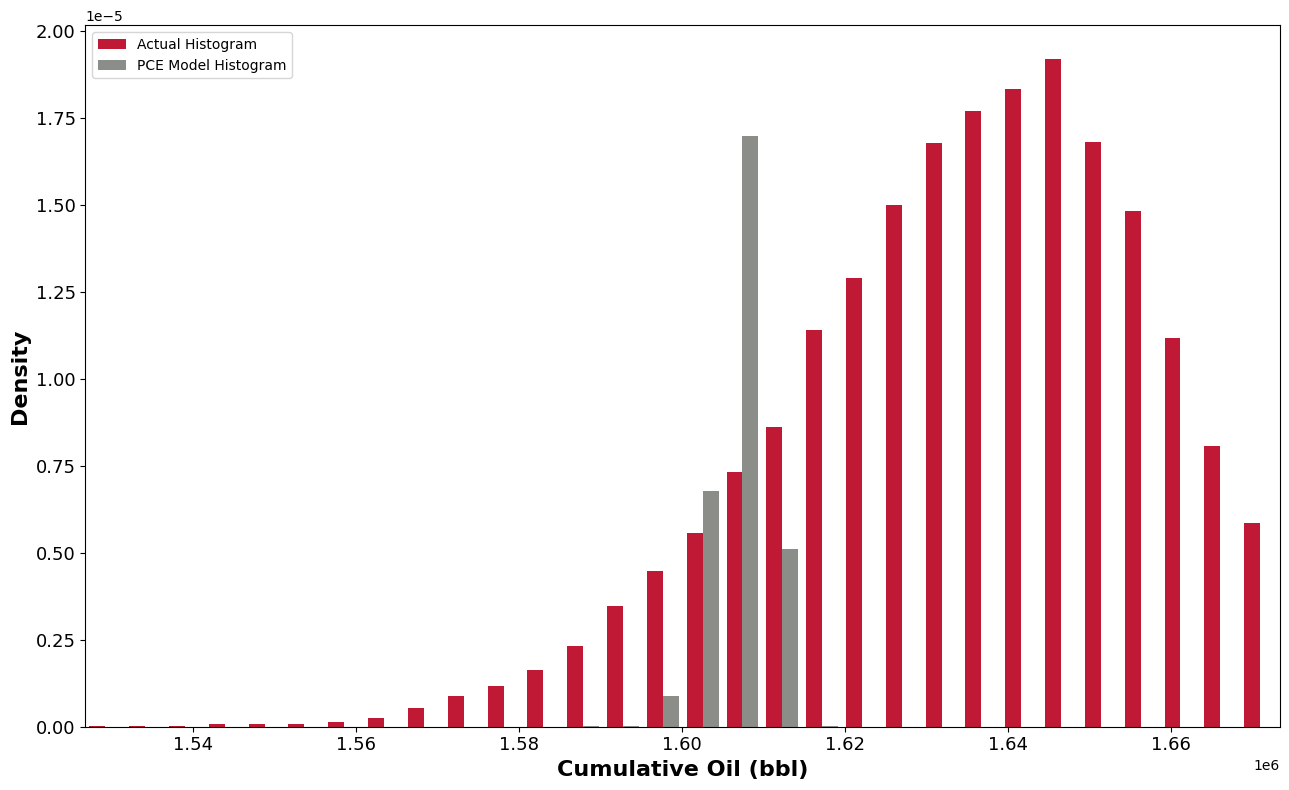

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Test_Data3' is your dataset. Uncomment and replace it with your actual data loading method
# Test_Data3 = pd.read_csv('your_data_file.csv')

# Number of bins
bins = 30

# Compute histograms manually
hist1, bin_edges = np.histogram(Test_Data['Cum_Oil'], bins=bins, density=True)
hist2, _ = np.histogram(Test_Data['Cum_Oil_PCE'], bins=bins, density=True)

# Width of each bar
bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # Adjust width to make sure they fit side by side

# Shift the bar positions for the second histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bar_shift = bar_width / 2

# Plotting the histograms of Cumulative Oil and Cumulative Oil PCE side by side
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the first histogram
plt.bar(bin_centers - bar_shift, hist1, width=bar_width, color="#B8001F", label='Actual Histogram', alpha=0.9)

# Plot the second histogram
plt.bar(bin_centers + bar_shift, hist2, width=bar_width, color='#181C14', label='PCE Model Histogram', alpha=0.5)

# Set the font size for x and y axis labels and title
plt.xlabel('Cumulative Oil (bbl)', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # Set x-tick properties
plt.yticks(fontsize=13)  # Set y-tick properties

# Add a legend in the upper-left position
plt.legend(loc='upper left')

# Add grid
plt.grid(False)

# Set the X-axis limits to the min and max values of 'Cum_Oil_PCE'
plt.xlim([Test_Data['Cum_Oil'].min(), Test_Data['Cum_Oil'].max()])

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Histogram 2184 Sample.png', dpi=300)
plt.show()

In [ ]:
# Calculate the P90, P50, and P10

# Calculate the P90, P50, and P10
p90 = np.percentile(df2['Cum_Oil'], 10)
p50 = np.percentile(df2['Cum_Oil'], 50)
p10 = np.percentile(df2['Cum_Oil'], 90)


p90_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 10)
p50_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 50)
p10_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 90)

# Print the results
print(f"P90: {p90}")
print(f"P50: {p50}")
print(f"P10: {p10}")

# Print the results
print(f"P90_PCE: {p90_PCE}")
print(f"P50_PCE: {p50_PCE}")
print(f"P10_PCE: {p10_PCE}")

P90: 1604672.0999999999
P50: 1636815.6
P10: 1660732.04
P90_PCE: 1604953.4762558618
P50_PCE: 1636970.6913482624
P10_PCE: 1660710.211745748


___________

_________

#**1540 SAMPLE**



In [ ]:
# Randomly sample 1500 rows from df2 with a defined random state for reproducibility
random_state = 42  # You can choose any integer as the random state
train_data5 = df2.sample(n=2548, random_state=random_state)

# Prepare the feature matrix X and target vector y
X = train_data5.drop(columns="Cum_Oil").to_numpy()  # Drop the target column to get the features
y = train_data5['Cum_Oil'].to_numpy()  # Extract the target column as a NumPy array

In [ ]:
X.shape

(2548, 3)

In [ ]:
train_data.shape

(1092, 4)

In [ ]:
# Determine the number of samples from the DataFrame
n_samples = len(X)

# Define normal distributions for each parameter
ccpor_dist = Normal(loc=4.5e-6, scale=4.83579e-7)
permi_multi_dist = Normal(loc=1.001, scale=0.107569)
por_multi_dist = Normal(loc=1.001, scale=0.107569)

# Create a list of these normal distributions
marginals = [ccpor_dist, permi_multi_dist, por_multi_dist]

# Create a joint distribution object with independent marginals
joint_distribution = JointIndependent(marginals=marginals)

# Generate samples
samples = joint_distribution.rvs(n_samples)

In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create the empty lists to store actual and predicted values
actual_values = []
predicted_values = []

# Step 2: Perform Leave-One-Out Cross-Validation (LOO-CV)
for i in range(len(X)):
    # Leave out one data point
    X_train = np.delete(X, i, axis=0)  # All points except the i-th
    y_train = np.delete(y, i)  # All targets except the i-th
    X_test = X[i].reshape(1, -1)  # The i-th point to be tested
    y_test = y[i]  # The actual target for the i-th point

    # Step 3: Generate a polynomial basis using the joint distribution for the PCE model
    polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

    # Step 4: Define the regression method and create the PCE model
    least_squares = LeastSquareRegression()
    pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

    # Step 5: Fit the PCE model on the training data (all points except the i-th point)
    pce.fit(X_train, y_train)

    # Step 6: Predict the left-out data point
    y_pred = pce.predict(X_test)

    # Step 7: Record the actual and predicted values
    actual_values.append(y_test)  # The actual value of the left-out point
    predicted_values.append(np.squeeze(y_pred))  # Ensure it's a scalar (flatten any potential 2D array)

# Step 8: Convert the lists to arrays for analysis and plotting
actual_values = np.array(actual_values).flatten()  # Ensure it's a flat 1D array
predicted_values = np.array(predicted_values).flatten()  # Ensure it's a flat 1D array

In [ ]:
# Step 9: Create a dataframe to store actual and predicted values
loo_cv_results = pd.DataFrame({
    'Cum_Oil': actual_values,
    'Cum_Oil_PCE': predicted_values
})

loo_cv_results.head()

,Cum_Oil,Cum_Oil_PCE
0,1631329.4,1.631921e+06
1,1643635.1,1.642284e+06
2,1673400.0,1.673206e+06
3,1667256.5,1.668215e+06
4,1633459.4,1.633522e+06


In [ ]:
# Define the maximum degree for the polynomial basis
max_degree = 11

# Create a polynomial basis using TotalDegreeBasis
polynomial_basis = TotalDegreeBasis(distributions=joint_distribution, max_degree=max_degree)

# Define the regression method
least_squares = LeastSquareRegression()

# Create the Polynomial Chaos Expansion (PCE) object
pce = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

# Fit the PCE model to the input (x) and output (y) data
pce.fit(X, y)

In [ ]:
moments=pce.get_moments()
moments

(1631146.0271521683, 699565687843.081)

In [ ]:
# Step 9: Perform Leave-One-Out Cross-Validation (LOO-CV) to assess the model
loo_error = pce.leaveoneout_error()

# Print the Leave-One-Out cross-validation error
print(f'Leave-One-Out Cross Validation Error (LOO-CV): {loo_error}')

Leave-One-Out Cross Validation Error (LOO-CV): 0.0663982


In [ ]:
# Get the remaining data that was not part of the sampled_1000
Test_Data = df2.drop(train_data5.index)
# Prepare the feature matrix X_test and target vector y_test for the test set
X_test = Test_Data.drop(columns="Cum_Oil").to_numpy()  # Drop the target column for testing features

y_test = pce.predict(X_test)

In [ ]:
X_test.shape

(14529, 3)

In [ ]:
# Add the predicted_y as a new column to the Z DataFrame
Test_Data['Cum_Oil_PCE'] = y_test

Test_Data.head()

,CCPOR,PERMI_MULTI,POR_MULTI,Cum_Oil,Cum_Oil_PCE
0,0.000005,1.001000,1.001000,1641502.0,1.641530e+06
1,0.000004,1.047771,1.100369,1658139.5,1.657834e+06
2,0.000004,1.021748,0.986743,1638181.8,1.637486e+06
4,0.000005,0.893916,1.116380,1642039.0,1.641893e+06
6,0.000004,0.988360,1.143735,1655225.8,1.655094e+06


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

n_samples = len(Test_Data)

# Predict on training and test sets
y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

error = np.sum(np.abs((y_test - y_test_PCE)/y_test))/n_samples

print('Mean rel. error, LSTSQ:', error)

Mean rel. error, LSTSQ: 0.0005897600795321538


In [ ]:
import numpy as np

# Assuming y_test and y_test_PCE are defined from the previous code.

# Step 1: Calculate the variance of y_test
mean_y_test = np.mean(y_test)
variance_y_test = np.sum((y_test - mean_y_test) ** 2)

# Step 2: Calculate the squared differences between actual and predicted values
squared_differences = np.sum((y_test - y_test_PCE) ** 2)

# Step 3: Compute the empirical error as per the formula
empirical_error = squared_differences / variance_y_test

print('Empirical error (normalized by variance):', empirical_error)

Empirical error (normalized by variance): 0.08593339371195782


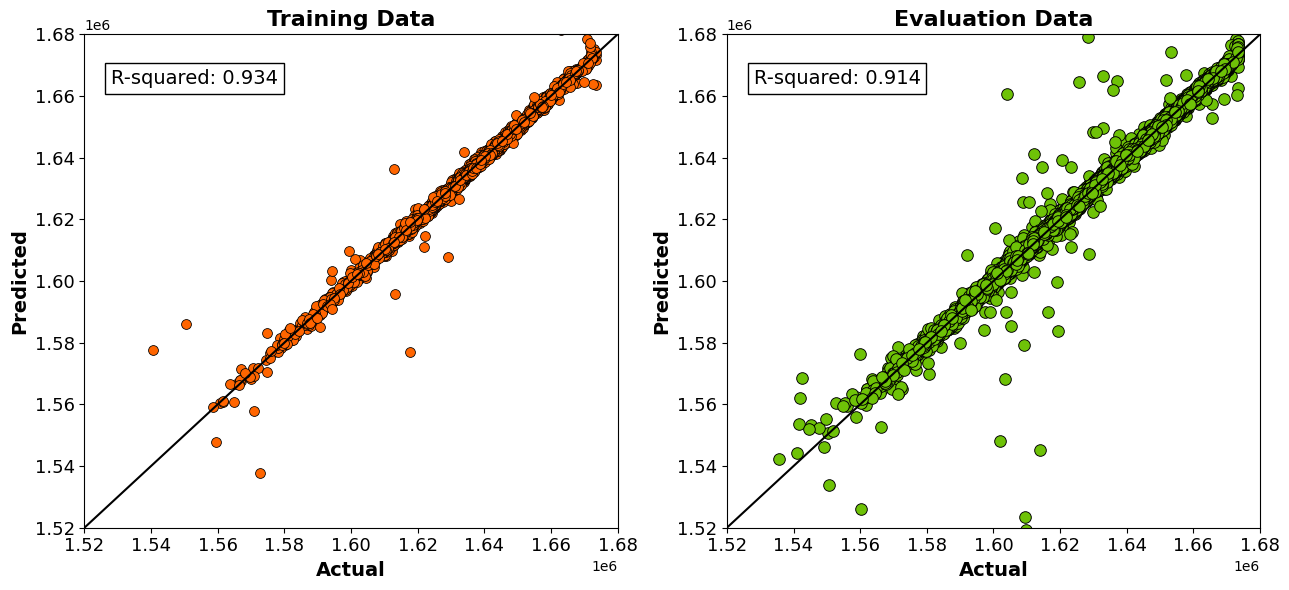

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import pandas as pd

# Provided datasets
y_train = loo_cv_results['Cum_Oil']
y_train_PCE = loo_cv_results['Cum_Oil_PCE']

y_test = Test_Data['Cum_Oil']
y_test_PCE = Test_Data['Cum_Oil_PCE']

# Set custom limits for both axes
x_min, x_max = 1.52e6, 1.68e6
y_min, y_max = 1.52e6, 1.68e6

# Calculate R-squared scores for training and test sets
train_r2 = r2_score(y_train, y_train_PCE)
test_r2 = r2_score(y_test, y_test_PCE)

# Create dataframes with the actual and predicted values for training and test sets
train_data1 = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_PCE})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_PCE})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

# Plot training set
sns.scatterplot(data=train_data1, x='Actual', y='Predicted', ax=axes[0], s=50, color='#FF6500', edgecolor='black')
axes[0].set_title('Training Data', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])

# Add grid line
#axes[0].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[0].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[0].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[0].tick_params(axis='y', labelsize=13, labelcolor='black')

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1], s=70, color='#6EC207', edgecolor='black')
axes[1].set_title('Evaluation Data', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Actual', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Predicted', fontsize=14, fontweight='bold')

# Set custom xlim and ylim
axes[1].set_xlim([x_min, x_max])
axes[1].set_ylim([y_min, y_max])

# Add grid line
#axes[1].grid(True)

# Add 1:1 line extending from (x_min, y_min) to (x_max, y_max)
axes[1].plot([x_min, x_max], [y_min, y_max], color='black', linestyle='-')

# Add R-squared score for test set as text inside the plot
axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=14,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Adjust tick label size and bold
axes[1].tick_params(axis='x', labelsize=13, labelcolor='black')
axes[1].tick_params(axis='y', labelsize=13, labelcolor='black')

plt.tight_layout()
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Crossplot 2548 Sample.png', dpi=300)
plt.show()

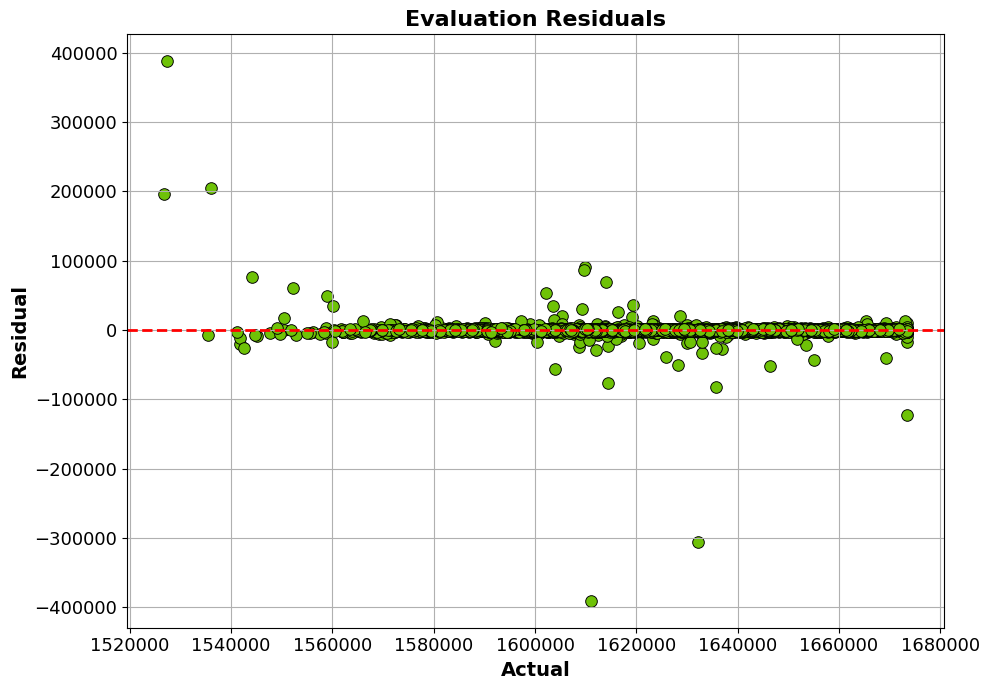

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import ScalarFormatter

# Calculate residuals for test set (evaluation data)
test_residuals = y_test - y_test_PCE

# Create a dataframe with the actual and residual values for test set
test_data_residual = pd.DataFrame({'Actual': y_test, 'Residual': test_residuals})

# Create the residual plot for evaluation data
fig, ax = plt.subplots(figsize=(10, 7))

# Plot test residuals
sns.scatterplot(data=test_data_residual, x='Actual', y='Residual', s=70, color='#6EC207', edgecolor='black')
ax.set_title('Evaluation Residuals', fontsize=16, fontweight='bold')
ax.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax.set_ylabel('Residual', fontsize=14, fontweight='bold')

# Turn off scientific notation for both axes
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().set_major_formatter(ScalarFormatter(useMathText=False))
ax.get_yaxis().set_major_formatter(ScalarFormatter(useMathText=False))

# Add grid line for better clarity
ax.grid(True)

# Add horizontal line at y=0 (no residuals)
ax.axhline(0, color='red', linestyle='--', linewidth=2)

# Adjust tick label size and bold
ax.tick_params(axis='x', labelsize=13, labelcolor='black')
ax.tick_params(axis='y', labelsize=13, labelcolor='black')

# Adjust the tick formatting style to plain (no scientific notation)
ax.ticklabel_format(style='plain')

plt.tight_layout()

# Save the figure (optional, uncomment to save)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Residual 2548 Sample.png', dpi=300)

# Display the plot
plt.show()

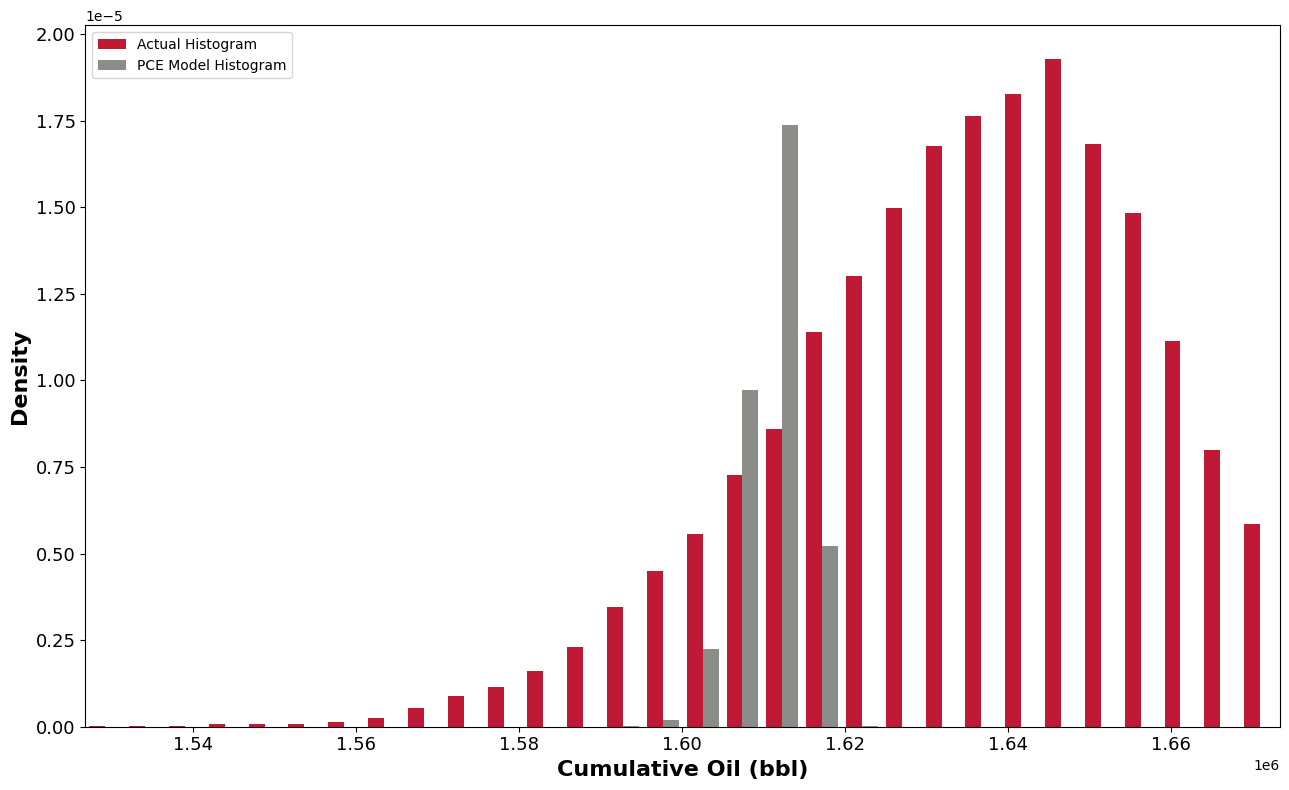

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Test_Data3' is your dataset. Uncomment and replace it with your actual data loading method
# Test_Data3 = pd.read_csv('your_data_file.csv')

# Number of bins
bins = 30

# Compute histograms manually
hist1, bin_edges = np.histogram(Test_Data['Cum_Oil'], bins=bins, density=True)
hist2, _ = np.histogram(Test_Data['Cum_Oil_PCE'], bins=bins, density=True)

# Width of each bar
bar_width = (bin_edges[1] - bin_edges[0]) * 0.4  # Adjust width to make sure they fit side by side

# Shift the bar positions for the second histogram
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bar_shift = bar_width / 2

# Plotting the histograms of Cumulative Oil and Cumulative Oil PCE side by side
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the first histogram
plt.bar(bin_centers - bar_shift, hist1, width=bar_width, color="#B8001F", label='Actual Histogram', alpha=0.9)

# Plot the second histogram
plt.bar(bin_centers + bar_shift, hist2, width=bar_width, color='#181C14', label='PCE Model Histogram', alpha=0.5)

# Set the font size for x and y axis labels and title
plt.xlabel('Cumulative Oil (bbl)', fontsize=16, fontweight='bold')
plt.ylabel('Density', fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # Set x-tick properties
plt.yticks(fontsize=13)  # Set y-tick properties

# Add a legend in the upper-left position
plt.legend(loc='upper left')

# Add grid
plt.grid(False)

# Set the X-axis limits to the min and max values of 'Cum_Oil_PCE'
plt.xlim([Test_Data['Cum_Oil'].min(), Test_Data['Cum_Oil'].max()])

plt.tight_layout()
# Save the figure (uncomment if needed)
fig.savefig('/content/drive/MyDrive/THESIS/Picture_Degree11/Histogram 2548 Sample.png', dpi=300)
plt.show()

In [ ]:
# Calculate the P90, P50, and P10

# Calculate the P90, P50, and P10
p90 = np.percentile(df2['Cum_Oil'], 10)
p50 = np.percentile(df2['Cum_Oil'], 50)
p10 = np.percentile(df2['Cum_Oil'], 90)


p90_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 10)
p50_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 50)
p10_PCE = np.percentile(Test_Data['Cum_Oil_PCE'], 90)

# Print the results
print(f"P90: {p90}")
print(f"P50: {p50}")
print(f"P10: {p10}")

# Print the results
print(f"P90_PCE: {p90_PCE}")
print(f"P50_PCE: {p50_PCE}")
print(f"P10_PCE: {p10_PCE}")

P90: 1604672.0999999999
P50: 1636815.6
P10: 1660732.04
P90_PCE: 1605004.6271831018
P50_PCE: 1637040.3627732112
P10_PCE: 1660677.8898622834
